# CSE 519: Assignment 3
# Ritika Nevatia
ritika.nevatia@stonybrook.edu
112007313


In [1]:
import os
import time
import gc
import warnings
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [32]:
def load_df(csv_path='/Users/Shared/Work/dsf/hw3/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df
train = load_df('/Users/Shared/Work/dsf/hw3/all/train.csv')
test = load_df('/Users/Shared/Work/dsf/hw3/all/test.csv')
gc.collect()

28

In [54]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

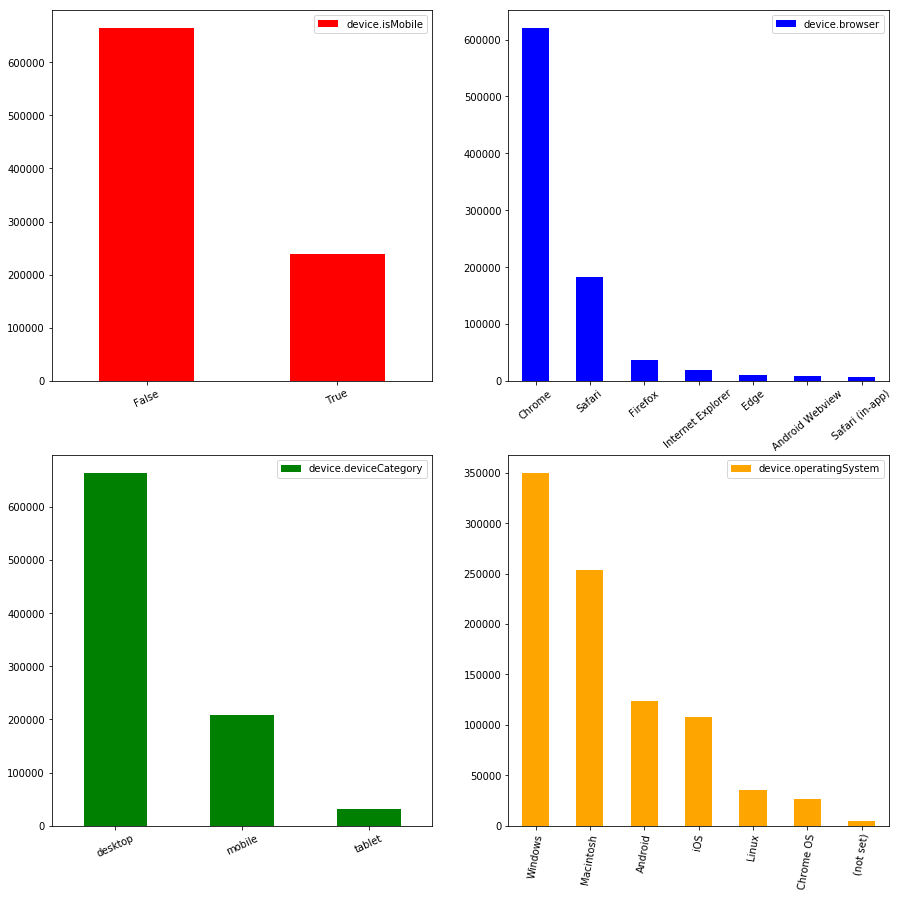

In [55]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
train["device.isMobile"].value_counts().plot(kind="bar",ax=axes[0][0],rot=25,legend="isMobile",color='red')
train["device.browser"].value_counts().head(7).plot(kind="bar",ax=axes[0][1],rot=40,legend="browser",color='blue')
train["device.deviceCategory"].value_counts().plot(kind="bar",ax=axes[1][0],rot=25,legend="deviceCategory",color='green')
train["device.operatingSystem"].value_counts().head(7).plot(kind="bar",ax=axes[1][1],rot=80,legend="operatingSystem",color='orange')


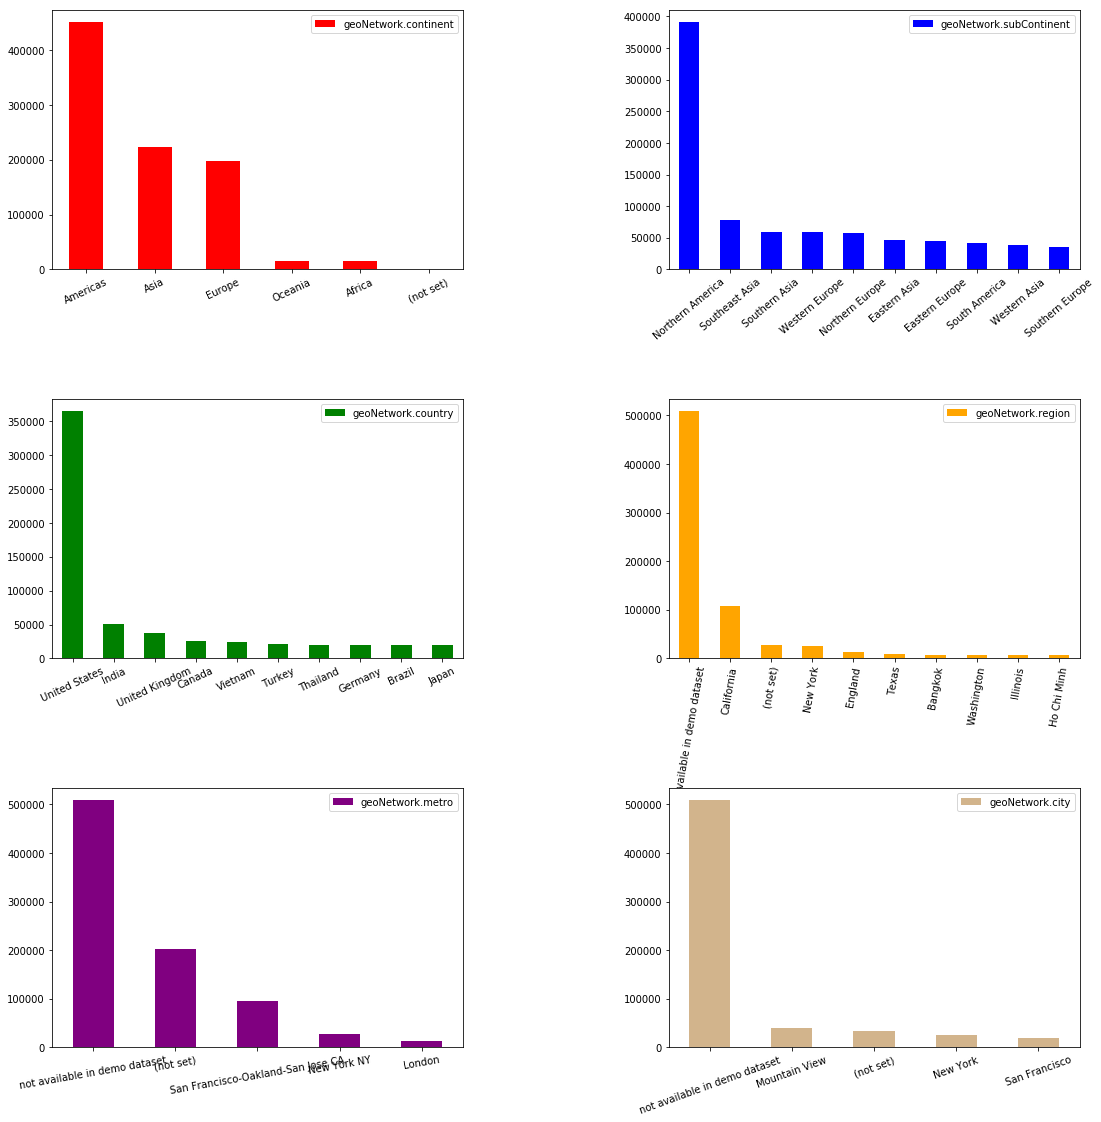

In [56]:
fig, axes = plt.subplots(3,2,figsize=(15,15))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

train["geoNetwork.continent"].value_counts().plot(kind="bar",ax=axes[0][0],rot=25,legend="continent",color='red')
train["geoNetwork.subContinent"].value_counts().head(10).plot(kind="bar",ax=axes[0][1],rot=40,legend="subContinent",color='blue')
train["geoNetwork.country"].value_counts().head(10).plot(kind="bar",ax=axes[1][0],rot=25,legend="country",color='green')
train["geoNetwork.region"].value_counts().head(10).plot(kind="bar",ax=axes[1][1],rot=80,legend="region",color='orange')
train["geoNetwork.metro"].value_counts().head(5).plot(kind="bar",ax=axes[2][0],rot=10,legend="metro",color='purple')
train["geoNetwork.city"].value_counts().head(5).plot(kind="bar",ax=axes[2][1],rot=20,legend="city",color='tan')

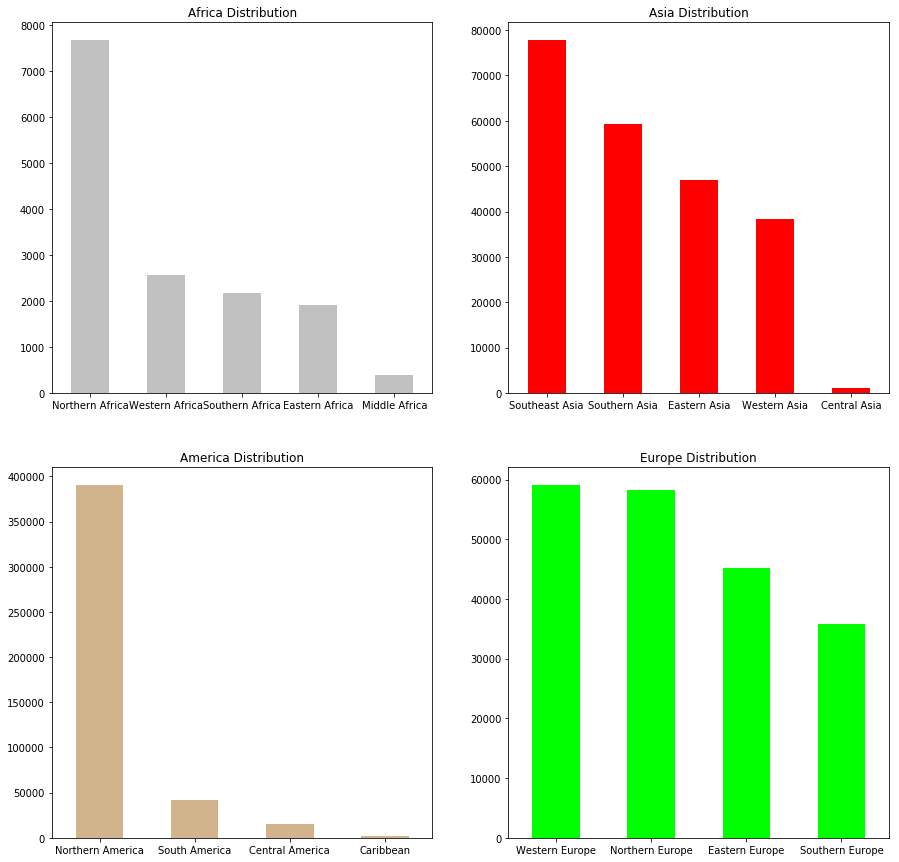

In [57]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
train[train["geoNetwork.continent"] == "Africa"]["geoNetwork.subContinent"].value_counts().plot(kind="bar" , ax=axes[0][0], title="Africa Distribution",rot=0,color="silver")
train[train["geoNetwork.continent"] == "Americas"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][0], title="America Distribution",rot=0,color="tan")
train[train["geoNetwork.continent"] == "Asia"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[0][1], title="Asia Distribution",rot=0,color="r")
train[train["geoNetwork.continent"] == "Europe"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][1],  title="Europe Distribution",rot=0,color="lime")


In [58]:
rev = train[["totals.transactionRevenue" , "date"]].dropna()
rev.head()

,totals.transactionRevenue,date
752,37860000,20160902
753,306670000,20160902
799,68030000,20160902
802,26250000,20160902
859,574150000,20160902


In [59]:
rev["totals.transactionRevenue"] = rev["totals.transactionRevenue"].astype(np.int64)

(array([7.03060e+05, 1.28391e+05, 3.84490e+04, 1.49430e+04, 9.48100e+03,
        4.35900e+03, 2.06200e+03, 1.51700e+03, 9.86000e+02, 4.05000e+02]),
 array([0.        , 0.59788858, 1.19577715, 1.79366573, 2.39155431,
        2.98944288, 3.58733146, 4.18522004, 4.78310861, 5.38099719,
        5.97888576]),
 <a list of 10 Patch objects>)

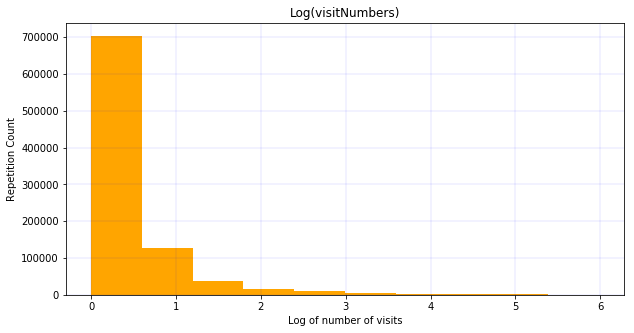

In [60]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title("Log(visitNumbers)")
ax.set_ylabel("Repetition Count")
ax.set_xlabel("Log of number of visits")
ax.grid(color="blue", linewidth=0.1)
ax.hist(np.log(train.visitNumber), color="orange")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


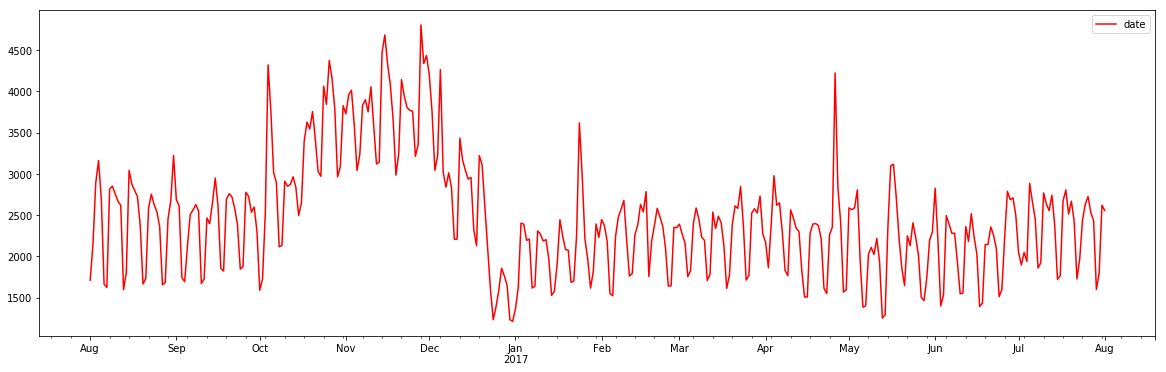

In [61]:
train.date_ = pd.to_datetime(train.date, format="%Y%m%d")
plt.figure(figsize=(20,6))
train.date_.value_counts().sort_index().plot(color = "red")
plt.legend()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


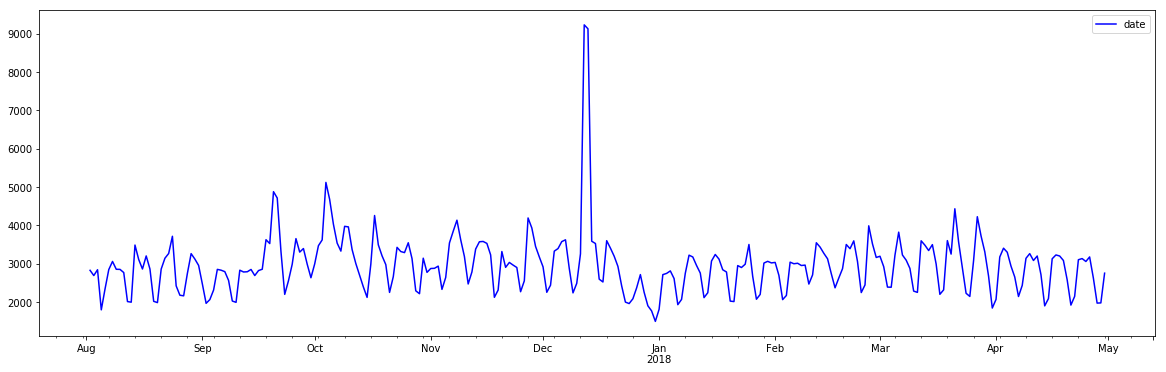

In [62]:
test.date_ = pd.to_datetime(test.date, format="%Y%m%d")
plt.figure(figsize=(20,6))
test.date_.value_counts().sort_index().plot(color = "blue")
plt.legend()

In [3]:
gdp_df = pd.read_csv('/Users/Shared/Work/dsf/hw3/WEO_Data.xls', encoding='latin-1', sep='\t', thousands=',')

In [64]:
gdp_df.head()

,Country,Units,Scale,2016,2017,Estimates Start After
0,Afghanistan,Purchasing power parity; international dollars,Units,1923276.0,1957577.0,2016.0
1,Albania,Purchasing power parity; international dollars,Units,11820515.0,12506645.0,2011.0
2,Algeria,Purchasing power parity; international dollars,Units,14955261.0,15237198.0,2016.0
3,Angola,Purchasing power parity; international dollars,Units,6783266.0,6752580.0,2015.0
4,Antigua and Barbuda,Purchasing power parity; international dollars,Units,25347436.0,26231545.0,2011.0


In [65]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 6 columns):
Country                  194 non-null object
Units                    193 non-null object
Scale                    193 non-null object
2016                     191 non-null float64
2017                     191 non-null float64
Estimates Start After    192 non-null float64
dtypes: float64(3), object(3)
memory usage: 9.2+ KB


In [66]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

In [4]:
train = pd.merge(train, gdp_df, left_on=['geoNetwork.country'], right_on=['Country'], how='outer')
test = pd.merge(test, gdp_df, left_on=['geoNetwork.country'], right_on=['Country'], how='outer')

In [5]:
pd.set_option('display.max_columns', None)

train.drop('Country', axis=1, inplace=True)
train.drop('Units', axis=1, inplace=True)
train.drop('Scale', axis=1, inplace=True)
train.drop('2016', axis=1, inplace=True)
train.drop('Estimates Start After', axis=1, inplace=True)
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,2017
0,Organic Search,20160902.0,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1.472830e+09,1.0,1.472830e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0
1,Organic Search,20160902.0,357659889600827884,357659889600827884_1472839882,Not Socially Engaged,1.472840e+09,1.0,1.472840e+09,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0
2,Organic Search,20160902.0,9675839814855309060,9675839814855309060_1472811887,Not Socially Engaged,1.472812e+09,1.0,1.472812e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Istanbul,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),dr.com.tr,not available in demo dataset,Istanbul,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0
3,Organic Search,20160902.0,9987056085213279488,9987056085213279488_1472842263,Not Socially Engaged,1.472842e+09,1.0,1.472842e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not av

In [6]:
test.drop('Country', axis=1, inplace=True)
test.drop('Units', axis=1, inplace=True)
test.drop('Scale', axis=1, inplace=True)
test.drop('2016', axis=1, inplace=True)
test.drop('Estimates Start After', axis=1, inplace=True)
test.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,2017
0,Organic Search,20171016.0,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1.508151e+09,2.0,1.508151e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),myrepublic.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,4,NaN,4,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google,93905495.0
1,Organic Search,20171016.0,394911561846949602,394911561846949602_1508177948,Not Socially Engaged,1.508178e+09,1.0,1.508178e+09,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),vqbn.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,12,1,11,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,93905495.0
2,Organic Search,20171016.0,8826908841852350020,8826908841852350020_1508144195,Not Socially Engaged,1.508144e+09,1.0,1.508144e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),singnet.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,7,1,7,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,93905495.0
3,Organic Search,20171016.0,0455927505163133323,0455927505163133323_1508147676,Not Socially Engaged,1.508148e+09,1.0,1.508148e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,n

In [7]:
def market_type(x):
    if  ('United States' in x):
        return 0
    elif  ('Canada' in x):
        return 0
    else:
        return 1
    
train['marketType'] = train['geoNetwork.country'].map(lambda x:market_type(str(x)))
test['marketType'] = test['geoNetwork.country'].map(lambda x:market_type(str(x)))


In [8]:
def ad_type(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'

train['adType'] = train['trafficSource.adContent'].map(lambda x:market_type(str(x)))
test['adType'] = test['trafficSource.adContent'].map(lambda x:market_type(str(x)))
    


In [9]:
def browser_type(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
train['browserType'] = train['device.browser'].map(lambda x:market_type(str(x)))
test['browserType'] = test['device.browser'].map(lambda x:market_type(str(x)))


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903686 entries, 0 to 903685
Data columns (total 59 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null float64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null float64
visitNumber                                          903653 non-null float64
visitStartTime                                       903653 non-null float64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                            

In [10]:
train['date_type'] = pd.to_datetime(train['date'])
test['date_type'] = pd.to_datetime(test['date'])
train['dayOfWeek'] = train['date_type'].dt.day_name()
test['dayOfWeek'] = test['date_type'].dt.day_name()
train.drop('date_type', axis=1, inplace=True)
test.drop('date_type', axis=1, inplace=True)

In [75]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,2017,marketType,adType,browserType,dayOfWeek
0,Organic Search,20160902.0,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1.472830e+09,1.0,1.472830e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0,1,1,1,Thursday
1,Organic Search,20160902.0,357659889600827884,357659889600827884_1472839882,Not Socially Engaged,1.472840e+09,1.0,1.472840e+09,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0,1,1,1,Thursday
2,Organic Search,20160902.0,9675839814855309060,9675839814855309060_1472811887,Not Socially Engaged,1.472812e+09,1.0,1.472812e+09,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Istanbul,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),dr.com.tr,not available in demo dataset,Istanbul,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,26892871.0,1,1,1,Thursday
3,Organic Search,20160902.0,9987056085213279488,9987056085213279488_1472842263,Not Socially Engaged,1.472842e+09,1.0,1.472842e+09,Chrome,not available in demo dataset,not available in demo dat

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903686 entries, 0 to 903685
Data columns (total 60 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null float64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null float64
visitNumber                                          903653 non-null float64
visitStartTime                                       903653 non-null float64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                            

In [11]:
set(train.columns).difference(set(test.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

In [12]:
cons_col = [i for i in train.columns if train[i].nunique(dropna=False)==1]
cons_col

['adType', 'browserType']

In [13]:
train = train.drop(cons_col + ['trafficSource.campaignCode'], axis=1)
test = test.drop(cons_col, axis=1)
gc.collect()

35

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903686 entries, 0 to 903685
Data columns (total 57 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null float64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null float64
visitNumber                                          903653 non-null float64
visitStartTime                                       903653 non-null float64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                            

In [14]:
def find_missing(data):
    count_missing = data.isnull().sum().values
    total = data.shape[0]
    ratio_missing = count_missing/total
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
train_missing = find_missing(train)
test_missing = find_missing(test)

In [15]:
train_missing.reset_index()[['index', 'missing_ratio']]\
    .merge(test_missing.reset_index()[['index', 'missing_ratio']], on='index', how='left')\
    .rename(columns={'index':'columns', 'missing_ratio_x':'train_missing_ratio', 'missing_ratio_y':'test_missing_ratio'})\
    .sort_values(['train_missing_ratio', 'test_missing_ratio'], ascending=False)\
    .query('train_missing_ratio>0')

,columns,train_missing_ratio,test_missing_ratio
41,trafficSource.adContent,0.987887,0.933155
39,totals.transactionRevenue,0.987258,NaN
42,trafficSource.adwordsClickInfo.adNetworkType,0.976253,0.933127
45,trafficSource.adwordsClickInfo.isVideoAd,0.976253,0.933127
46,trafficSource.adwordsClickInfo.page,0.976253,0.933127
47,trafficSource.adwordsClickInfo.slot,0.976253,0.933127
44,trafficSource.adwordsClickInfo.gclId,0.976141,0.933067
49,trafficSource.isTrueDirect,0.696792,0.676267
52,trafficSource.referralPath,0.633788,0.707570
50,trafficSource.keyword,0.556567,0.485965


In [16]:
train_idx = train.fullVisitorId
test_idx = test.fullVisitorId
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float').fillna(0)
train_y = train["totals.transactionRevenue"]
train_target = np.log1p(train.groupby("fullVisitorId")["totals.transactionRevenue"].sum())


In [17]:
train.drop(['fullVisitorId', 'sessionId', 'visitId'], axis = 1, inplace = True)
test.drop(['fullVisitorId', 'sessionId', 'visitId'], axis = 1, inplace = True)
num_col = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']
for i in num_col:
    train[i] = train[i].astype('float').fillna(0)
    test[i] = test[i].astype('float').fillna(0)
cat_col = [e for e in train.columns.tolist() if e not in num_col]
cat_col.remove('date')
cat_col.remove('totals.transactionRevenue')
for i in cat_col:
    lab_en = LabelEncoder()
    train[i] = train[i].fillna('not known')
    test[i] = test[i].fillna('not known')
    lab_en.fit(list(train[i].astype('str')) + list(test[i].astype('str')))
    train[i] = lab_en.transform(list(train[i].astype('str')))
    test[i] = lab_en.transform(test[i].astype('str'))

# Probability Function

In [96]:
prob_df = pd.DataFrame()
prob_df["fullVisitorId"] = train_idx
prob_df["visitNumber"] = train["visitNumber"]

top = prob_df.groupby("fullVisitorId")["visitNumber"].sum().reset_index()
total_count = top["visitNumber"].sum()
top["probability_visitNumber"] = top["visitNumber"]/total_count
sorted_top1 = top.sort_values("probability_visitNumber", ascending=False)

sorted_top1["rank_vn"] = sorted_top1["probability_visitNumber"].rank(ascending=False)

print(sorted_top1.head(20))

              fullVisitorId  visitNumber  probability_visitNumber  rank_vn
58716   0824839726118485274      63315.0                 0.030935      1.0
139589  1957458976293878100      50447.0                 0.024648      2.0
257343  3608475193341679870      36988.0                 0.018072      3.0
132193  1856749147915772585      36688.0                 0.017926      4.0
545156  7634897085866546110      14812.0                 0.007237      5.0
233127  3269834865385146569      13793.0                 0.006739      6.0
350356  4913801338365738862      12943.0                 0.006324      7.0
148455  2082625651279391786      12828.0                 0.006268      8.0
51304   0720311197761340948      11781.0                 0.005756      9.0
16720   0232377434237234751      11047.0                 0.005398     10.0
287807  4038076683036146727      10833.0                 0.005293     11.0
67614   0949718915643445721      10432.0                 0.005097     12.0
263443  36942340285231658

In [99]:
prob_df["totals.pageviews"] = train["totals.pageviews"]
top = prob_df.groupby("fullVisitorId")["totals.pageviews"].sum().reset_index()
total_count = top["totals.pageviews"].sum()
top["probability_pv"] = top["totals.pageviews"]/total_count
sorted_top2 = top.sort_values("probability_pv", ascending=False)
sorted_top2["rank_pv"] = sorted_top2["totals.pageviews"].rank(ascending=False)
print(sorted_top2.head(20))

              fullVisitorId  totals.pageviews  probability_pv  rank_pv
139589  1957458976293878100            4160.0        0.001196      1.0
58716   0824839726118485274            2707.0        0.000778      2.0
132193  1856749147915772585            1715.0        0.000493      3.0
706656  9894955795481014038            1496.0        0.000430      4.0
545156  7634897085866546110            1006.0        0.000289      5.0
350356  4913801338365738862             858.0        0.000247      6.0
371377  5208937953046059083             856.0        0.000246      7.0
16720   0232377434237234751             851.0        0.000245      8.0
156451  2194592743396253647             823.0        0.000237      9.0
557953  7813149961404844386             815.0        0.000234     10.0
534288  7483600664917507409             785.0        0.000226     11.0
585497  8197879643797712877             782.0        0.000225     12.0
521958  7311242886083854158             773.0        0.000222     13.0
344724

In [100]:
prob_df["totals.hits"] = train["totals.hits"]
top = prob_df.groupby("fullVisitorId")["totals.hits"].sum().reset_index()
total_count = top["totals.hits"].sum()
top["probability_hits"] = top["totals.hits"]/total_count
sorted_top3 = top.sort_values("probability_hits", ascending=False)
sorted_top3["rank_hits"] = sorted_top3["totals.hits"].rank(ascending=False)
print(sorted_top3.head(20))

              fullVisitorId  totals.hits  probability_hits  rank_hits
139589  1957458976293878100       4995.0          0.001203        1.0
58716   0824839726118485274       3378.0          0.000813        2.0
132193  1856749147915772585       2174.0          0.000523        3.0
706656  9894955795481014038       1602.0          0.000386        4.0
545156  7634897085866546110       1271.0          0.000306        5.0
534288  7483600664917507409       1091.0          0.000263        6.0
16720   0232377434237234751       1067.0          0.000257        7.0
350356  4913801338365738862       1047.0          0.000252        8.0
585497  8197879643797712877       1046.0          0.000252        9.0
521958  7311242886083854158       1040.0          0.000250       10.0
398871  5590743844926892757        993.0          0.000239       11.0
482512  6760732402251466726        989.0          0.000238       12.0
557953  7813149961404844386        986.0          0.000237       13.0
156451  219459274339

In [109]:
prob_ranking_merged = pd.merge(sorted_top1.head(50), sorted_top2.head(50), left_on=['fullVisitorId'], right_on=['fullVisitorId'], how='outer')

prob_ranking_merged = pd.merge(prob_ranking_merged, sorted_top3.head(50), left_on=['fullVisitorId'], right_on=['fullVisitorId'], how='outer')

#prob_ranking_merged["rank_vn"] = prob_ranking_merged["rank_vn"].fillna(0)
#prob_ranking_merged["rank_pv"] = prob_ranking_merged["rank_pv"].fillna(0)
#prob_ranking_merged["rank_hits"] = prob_ranking_merged["rank_hits"].fillna(0)

prob_ranking_merged["total_rank"] = prob_ranking_merged["rank_vn"] + prob_ranking_merged["rank_pv"] + prob_ranking_merged["rank_hits"]

prob_ranking_merged.sort_values("total_rank", ascending=True)


,fullVisitorId,visitNumber,probability_visitNumber,rank_vn,totals.pageviews,probability_pv,rank_pv,totals.hits,probability_hits,rank_hits,total_rank
1,1957458976293878100,50447.0,0.024648,2.0,4160.0,0.001196,1.0,4995.0,0.001203,1.0,4.0
0,0824839726118485274,63315.0,0.030935,1.0,2707.0,0.000778,2.0,3378.0,0.000813,2.0,5.0
3,1856749147915772585,36688.0,0.017926,4.0,1715.0,0.000493,3.0,2174.0,0.000523,3.0,10.0
4,7634897085866546110,14812.0,0.007237,5.0,1006.0,0.000289,5.0,1271.0,0.000306,5.0,15.0
6,4913801338365738862,12943.0,0.006324,7.0,858.0,0.000247,6.0,1047.0,0.000252,8.0,21.0
9,0232377434237234751,11047.0,0.005398,10.0,851.0,0.000245,8.0,1067.0,0.000257,7.0,25.0
18,7813149961404844386,6451.0,0.003152,19.0,815.0,0.000234,10.0,986.0,0.000237,13.0,42.0
21,2194592743396253647,5717.0,0.002793,22.0,823.0,0.000237,9.0,978.0,0.000235,14.0,45.0
44,5208937953046059083,2526.0,0.001234,45.0,856.0,0.000246,7.0,934.0,0.000225,17.0,69.0
15,6254908847172458133,6820.0,0.003332,16.0,619.0,0.000178,25.0,752.0,0.000181,31.0,72.0


In [20]:
y_train = np.log1p(train["totals.transactionRevenue"])
x_train = train.drop(["totals.transactionRevenue"], axis=1)
x_test = test.copy()


# Train

In [89]:

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    trn_x, trn_y = x_train.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[457]	training's rmse: 1.85029	valid_1's rmse: 0.324253
Fold  1 RMSE : 0.323986


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.77835	valid_1's rmse: 0.683013
Early stopping, best iteration is:
[1357]	training's rmse: 1.76207	valid_1's rmse: 0.682217
Fold  2 RMSE : 0.681136


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.37219	valid_1's rmse: 2.38438
[2000]	training's rmse: 1.33423	valid_1's rmse: 2.36218
[3000]	training's rmse: 1.30862	valid_1's rmse: 2.35449
[4000]	training's rmse: 1.28711	valid_1's rmse: 2.34935
[5000]	training's rmse: 1.26936	valid_1's rmse: 2.34646
Early stopping, best iteration is:
[5089]	training's rmse: 1.26775	valid_1's rmse: 2.34623
Fold  3 RMSE : 2.344776


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31386	valid_1's rmse: 2.51139
[2000]	training's rmse: 1.2759	valid_1's rmse: 2.49224
Early stopping, best iteration is:
[2765]	training's rmse: 1.2554	valid_1's rmse: 2.4862
Fold  4 RMSE : 2.485008


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.73758	valid_1's rmse: 1.03095
[2000]	training's rmse: 1.70023	valid_1's rmse: 1.02036
[3000]	training's rmse: 1.67283	valid_1's rmse: 1.01683
Early stopping, best iteration is:
[3074]	training's rmse: 1.67148	valid_1's rmse: 1.01679
Fold  5 RMSE : 1.015274


In [90]:
print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

Session-level CV-score: 1.37
 
User-level score: 1.6123
 
training time: 10 mins


In [91]:
test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("submit.csv", index=False)

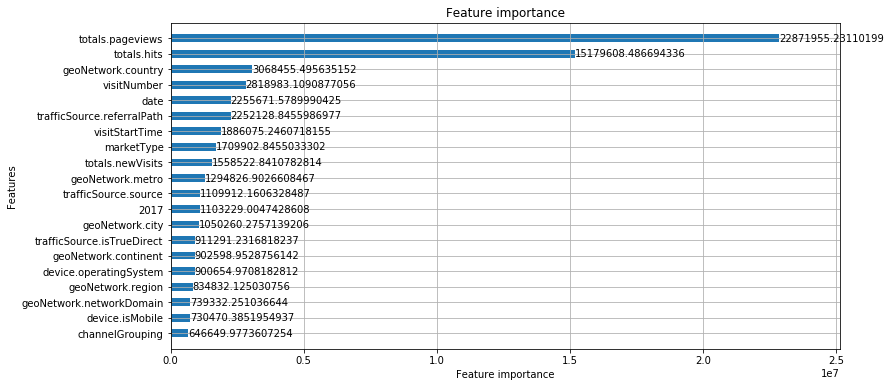

In [92]:
lgb.plot_importance(lgb_model, height=0.5, max_num_features=20, ignore_zero = False, figsize = (12,6), importance_type ='gain')
plt.show()

In [93]:
train.corr(method='pearson')

,channelGrouping,date,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,2017,marketType,dayOfWeek
channelGrouping,1.000000,-0.236886,0.011466,-0.036800,-0.164112,0.100624,0.011466,0.011466,-0.186820,0.011466,-0.230171,0.011466,0.011466,0.011466,0.011466,0.011466,0.011466,0.030185,0.011466,0.011466,0.011466,-0.006282,0.011466,0.038730,-0.045936,0.011466,0.011466,-0.014529,0.110806,0.011466,0.017590,0.062654,0.063994,-0.067364,0.082264,-0.071030,-0.006646,0.011466,-0.021286,-0.032302,0.011466,-0.028202,-0.032303,-0.032293,-0.031947,-0.201301,0.467864,0.282834,0.802630,-0.509481,0.939053,-0.224743,0.215656,0.011466
date,-0.236886,1.000000,NaN,0.007536,0.880936,-0.088072,NaN,NaN,0.118133,NaN,0.146148,NaN,NaN,NaN,NaN,NaN,NaN,0.001192,NaN,NaN,NaN,0.051625,NaN,0.007571,-0.008117,NaN,NaN,0.062643,-0.077520,NaN,0.032589,-0.040016,0.002479,-0.018395,-0.043902,-0.012146,0.003188,NaN,-0.051095,-0.018888,NaN,-0.005973,-0.018867,-0.018907,-0.018385,0.013333,-0.083313,-0.158028,-0.122398,0.024930,-0.262463,0.114128,-0.085404,NaN
socialEngagementType,0.011466,NaN,1.000000,-0.001474,-0.705206,0.026293,1.000000,1.000000,0.015478,1.000000,0.023766,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.008183,1.000000,1.000000,1.000000,0.004305,1.000000,0.022398,0.005586,1.000000,1.000000,0.004434,0.002657,1.000000,0.004551,0.012515,-0.006027,-0.002881,-0.011313,-0.003311,-0.000195,1.000000,0.000622,0.000942,1.000000,0.000823,0.000942,0.000942,0.000932,0.117426,0.003986,0.005269,-0.000602,0.003173,0.004904,-0.005053,0.005273,1.000000
visitNumber,-0.036800,0.007536,-0.001474,1.000000,0.002506,-0.042104,-0.001474,-0.001474,-0.032287,-0.001474,-0.037691,-0.001474,-0.001474,-0.001474,-0.001474,-0.001474,-0.001474,0.007164,-0.001474,-0.001474,-0.001474,0.003616,-0.001474,-0.064838,0.052182,-0.001474,-0.001474,0.014937,-0.046552,-0.001474,-0.003238,-0.025541,-0.023745,0.041321,-0.255044,0.043337,0.051367,-0.001474,-0.033052,-0.001335,-0.001474,0.000322,-0.001333,-0.001346,-0.000960,-0.004429,-0.181696,0.003198,-0.033188,-0.029875,-0.046518,0.048679,-0.096729,-0.001474
visitStartTime,-0.164112,0.880936,-0.705206,0.002506,1.000000,-0.066757,-0.705206,-0.705206,0.071518,-0.705206,0.085543,-0.705206,-0.705206,-0.705206,-0.705206,-0.705206,-0.705206,-0.008923,-0.705206,-0.705206,-0.705206,0.017869,-0.705206,-0.014863,-0.004350,-0.705206,-0.705206,0.025625,-0.056860,-0.705206,0.007656,-0.034235,0.004158,-0.017608,-0.021115,-0.013448,0.002069,-0.705206,-0.033411,-0.021640,-0.705206,-0.009520,-0.021634,-0.021657,-0.021203,-0.073612,-0.054702,-0.114066,-0.077127,0.007839,-0.178594,0.079062,-0.060367,-0.705206
device.browser,0.100624,-0.088072,0.026293,-0.042104,-0.066757,1.000000,0.026293,0.026293,0.274410,0.026293,0.272339,0.026293,0.026293,0.026293,0.026293,0.026293,0.026293,0.152662,0.026293,0.026293,0.026293,0.026461,0.026293,0.042714,-0.005837,0.026293,0.026293,-0.000761,0.0907

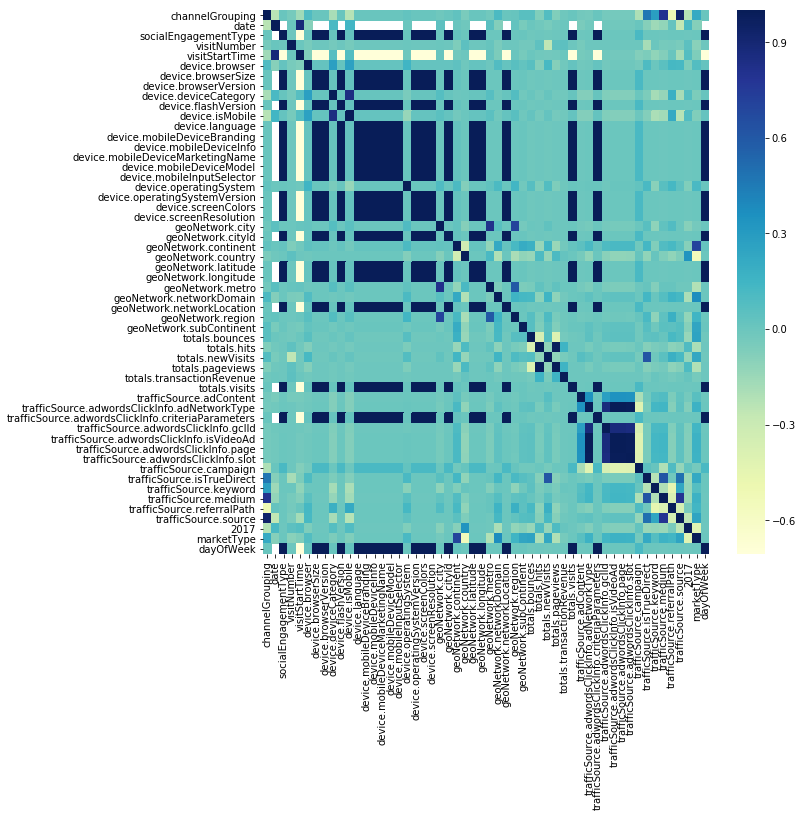

In [18]:
plt.subplots(figsize=(10,10))
corr = train.corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="YlGnBu")

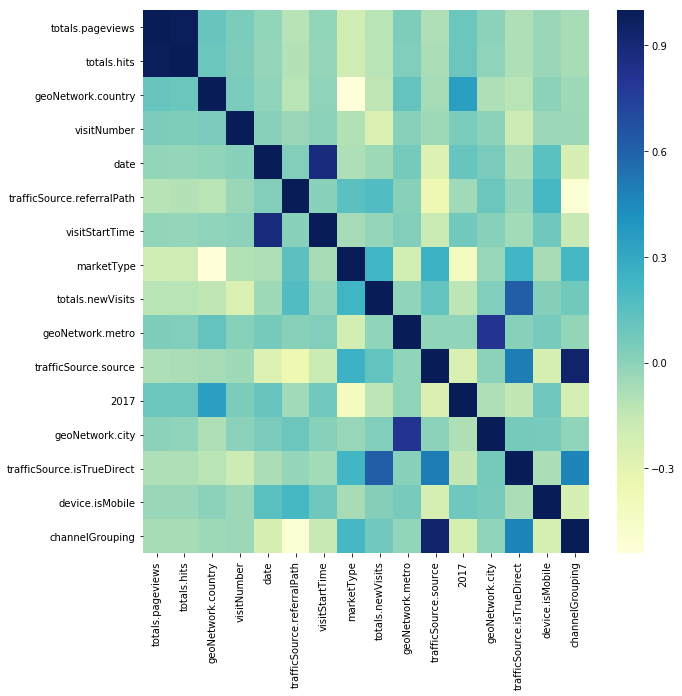

In [28]:
sub_train = train[["totals.pageviews", "totals.hits", "geoNetwork.country", "visitNumber", "date", "trafficSource.referralPath", "visitStartTime", "marketType", "totals.newVisits", "geoNetwork.metro", "trafficSource.source", "2017", "geoNetwork.city", "trafficSource.isTrueDirect", "device.isMobile", "channelGrouping"]]

plt.subplots(figsize=(10,10))
corr = sub_train.corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="YlGnBu")

In [110]:
print(type(lgb_model))

<class 'lightgbm.basic.Booster'>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn import datasets

n_classes = np.unique(train_y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X), 2200))

# Add noisy data to the informative features for make the task harder
#train = np.c_[train, E]

svm = SVC(kernel='linear')
cv = StratifiedKFold(2)

train = np.nan_to_num(train)

score, permutation_scores, pvalue = permutation_test_score(svm, train, train_y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# #############################################################################
# View histogram of permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
# plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
# plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


In [21]:

x_train_no_pv = x_train.copy(deep=True)
x_train_no_pv.drop('totals.pageviews', axis = 1, inplace = True)
x_test = test.copy()
x_test.drop('totals.pageviews', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_1.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 1.89172	valid_1's rmse: 0.325545
Fold  1 RMSE : 0.325233


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[515]	training's rmse: 1.88378	valid_1's rmse: 0.691198
Fold  2 RMSE : 0.691039


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.42499	valid_1's rmse: 2.46021
[2000]	training's rmse: 1.39813	valid_1's rmse: 2.44509
[3000]	training's rmse: 1.38192	valid_1's rmse: 2.44247
Early stopping, best iteration is:
[3678]	training's rmse: 1.37281	valid_1's rmse: 2.44156
Fold  3 RMSE : 2.440392


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.36519	valid_1's rmse: 2.5884
[2000]	training's rmse: 1.3378	valid_1's rmse: 2.57724
Early stopping, best iteration is:
[2409]	training's rmse: 1.32953	valid_1's rmse: 2.57632
Fold  4 RMSE : 2.574860


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.81527	valid_1's rmse: 1.0672
[2000]	training's rmse: 1.79471	valid_1's rmse: 1.06425
Early stopping, best iteration is:
[2081]	training's rmse: 1.79351	valid_1's rmse: 1.06421
Fold  5 RMSE : 1.062379
Session-level CV-score: 1.4188
 
User-level score: 1.6763
 
training time: 8 mins


In [22]:
x_train_no_pv = x_train.copy(deep=True)
x_train_no_pv.drop('visitStartTime', axis = 1, inplace = True)
x_test = test.copy()
x_test.drop('visitStartTime', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_2.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[450]	training's rmse: 1.84495	valid_1's rmse: 0.323605
Fold  1 RMSE : 0.323248


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.77899	valid_1's rmse: 0.684919
Early stopping, best iteration is:
[1117]	training's rmse: 1.77291	valid_1's rmse: 0.684661
Fold  2 RMSE : 0.683880


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.37336	valid_1's rmse: 2.38341
[2000]	training's rmse: 1.3364	valid_1's rmse: 2.36091
[3000]	training's rmse: 1.31206	valid_1's rmse: 2.3529
[4000]	training's rmse: 1.29143	valid_1's rmse: 2.34804
[5000]	training's rmse: 1.2743	valid_1's rmse: 2.34579
Early stopping, best iteration is:
[5530]	training's rmse: 1.26605	valid_1's rmse: 2.34518
Fold  3 RMSE : 2.343569


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31599	valid_1's rmse: 2.51
[2000]	training's rmse: 1.27897	valid_1's rmse: 2.48946
Early stopping, best iteration is:
[2702]	training's rmse: 1.26024	valid_1's rmse: 2.48316
Fold  4 RMSE : 2.481859


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.7617	valid_1's rmse: 1.05176
[2000]	training's rmse: 1.73368	valid_1's rmse: 1.04756
Early stopping, best iteration is:
[2697]	training's rmse: 1.71803	valid_1's rmse: 1.04651
Fold  5 RMSE : 1.045300
Session-level CV-score: 1.3756
 
User-level score: 1.6141
 
training time: 12 mins


In [23]:
x_train_no_pv = x_train.copy(deep=True)
x_train_no_pv.drop('channelGrouping', axis = 1, inplace = True)
x_test = test.copy()
x_test.drop('channelGrouping', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_3.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[411]	training's rmse: 1.84768	valid_1's rmse: 0.324209
Fold  1 RMSE : 0.323935


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.77554	valid_1's rmse: 0.684748
Early stopping, best iteration is:
[1144]	training's rmse: 1.76717	valid_1's rmse: 0.68446
Fold  2 RMSE : 0.683559


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.37033	valid_1's rmse: 2.38123
[2000]	training's rmse: 1.33249	valid_1's rmse: 2.35923
[3000]	training's rmse: 1.30659	valid_1's rmse: 2.35104
[4000]	training's rmse: 1.28412	valid_1's rmse: 2.34571
[5000]	training's rmse: 1.26697	valid_1's rmse: 2.34363
Early stopping, best iteration is:
[5218]	training's rmse: 1.26362	valid_1's rmse: 2.34323
Fold  3 RMSE : 2.341761


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31231	valid_1's rmse: 2.50825
[2000]	training's rmse: 1.27421	valid_1's rmse: 2.4894
[3000]	training's rmse: 1.24857	valid_1's rmse: 2.48299
Early stopping, best iteration is:
[3068]	training's rmse: 1.24721	valid_1's rmse: 2.48268
Fold  4 RMSE : 2.481508


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.7575	valid_1's rmse: 1.05179
[2000]	training's rmse: 1.72727	valid_1's rmse: 1.04759
[3000]	training's rmse: 1.7037	valid_1's rmse: 1.04515
[4000]	training's rmse: 1.68309	valid_1's rmse: 1.04419
Early stopping, best iteration is:
[3938]	training's rmse: 1.68429	valid_1's rmse: 1.04409
Fold  5 RMSE : 1.042785
Session-level CV-score: 1.3747
 
User-level score: 1.6133
 
training time: 13 mins


In [24]:
x_train_no_pv = x_train.copy(deep=True)
x_train_no_pv.drop('geoNetwork.country', axis = 1, inplace = True)
x_test = test.copy()
x_test.drop('geoNetwork.country', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_4.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[703]	training's rmse: 1.81849	valid_1's rmse: 0.324095
Fold  1 RMSE : 0.322757


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[181]	training's rmse: 1.90486	valid_1's rmse: 0.691789
Fold  2 RMSE : 0.691787


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.37176	valid_1's rmse: 2.38296
[2000]	training's rmse: 1.33361	valid_1's rmse: 2.36042
[3000]	training's rmse: 1.30806	valid_1's rmse: 2.35213
[4000]	training's rmse: 1.28596	valid_1's rmse: 2.34688
Early stopping, best iteration is:
[4419]	training's rmse: 1.27839	valid_1's rmse: 2.34595
Fold  3 RMSE : 2.344816


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31383	valid_1's rmse: 2.51115
[2000]	training's rmse: 1.27557	valid_1's rmse: 2.49121
Early stopping, best iteration is:
[2724]	training's rmse: 1.2555	valid_1's rmse: 2.48507
Fold  4 RMSE : 2.484056


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.76426	valid_1's rmse: 1.0541
[2000]	training's rmse: 1.73626	valid_1's rmse: 1.04982
[3000]	training's rmse: 1.71463	valid_1's rmse: 1.04671
Early stopping, best iteration is:
[3323]	training's rmse: 1.70837	valid_1's rmse: 1.04638
Fold  5 RMSE : 1.044879
Session-level CV-score: 1.3777
 
User-level score: 1.6171
 
training time: 10 mins


In [25]:
x_train_no_pv = x_train.copy(deep=True)
x_train_no_pv.drop('date', axis = 1, inplace = True)
x_test = test.copy()
x_test.drop('date', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_5.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[405]	training's rmse: 1.85209	valid_1's rmse: 0.324492
Fold  1 RMSE : 0.324260


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.77805	valid_1's rmse: 0.684338
Early stopping, best iteration is:
[1168]	training's rmse: 1.76861	valid_1's rmse: 0.683877
Fold  2 RMSE : 0.682915


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.37252	valid_1's rmse: 2.38275
[2000]	training's rmse: 1.33555	valid_1's rmse: 2.36072
[3000]	training's rmse: 1.31076	valid_1's rmse: 2.35206
[4000]	training's rmse: 1.28894	valid_1's rmse: 2.34573
Early stopping, best iteration is:
[4554]	training's rmse: 1.28019	valid_1's rmse: 2.34503
Fold  3 RMSE : 2.343587


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31496	valid_1's rmse: 2.50795
[2000]	training's rmse: 1.27765	valid_1's rmse: 2.48746
Early stopping, best iteration is:
[2724]	training's rmse: 1.25822	valid_1's rmse: 2.48178
Fold  4 RMSE : 2.480462


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.76338	valid_1's rmse: 1.05377
[2000]	training's rmse: 1.73602	valid_1's rmse: 1.04969
[3000]	training's rmse: 1.71523	valid_1's rmse: 1.04789
[4000]	training's rmse: 1.69721	valid_1's rmse: 1.04644
[5000]	training's rmse: 1.68164	valid_1's rmse: 1.04538
Early stopping, best iteration is:
[5406]	training's rmse: 1.67583	valid_1's rmse: 1.04495
Fold  5 RMSE : 1.042971
Session-level CV-score: 1.3748
 
User-level score: 1.6143
 
training time: 13 mins


In [26]:
x_train_no_pv = x_train.copy(deep=True)

x_train_no_pv.drop('device.isMobile', axis = 1, inplace = True)
x_train_no_pv.drop('channelGrouping', axis = 1, inplace = True)
x_train_no_pv.drop('geoNetwork.networkDomain', axis = 1, inplace = True)
x_train_no_pv.drop('geoNetwork.region', axis = 1, inplace = True)


x_test = test.copy()
x_test.drop('device.isMobile', axis = 1, inplace = True)
x_test.drop('channelGrouping', axis = 1, inplace = True)
x_test.drop('geoNetwork.networkDomain', axis = 1, inplace = True)
x_test.drop('geoNetwork.region', axis = 1, inplace = True)

folds = KFold(n_splits=5,random_state=6)
oof_preds = np.zeros(x_train_no_pv.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train_no_pv, y_train)):
    trn_x, trn_y = x_train_no_pv.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train_no_pv.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
              "num_leaves" : 30, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_pred[sub_pred<0] = 0
    sub_preds += sub_pred
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))
    

print('Session-level CV-score:', str(round(valid_score/folds.n_splits,4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId":train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

test_pred = pd.DataFrame({"fullVisitorId":test_idx})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("perm_6.csv", index=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[470]	training's rmse: 1.83814	valid_1's rmse: 0.323722
Fold  1 RMSE : 0.323353


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[366]	training's rmse: 1.82904	valid_1's rmse: 0.684849
Fold  2 RMSE : 0.684744


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.36969	valid_1's rmse: 2.3781
[2000]	training's rmse: 1.33606	valid_1's rmse: 2.3598
[3000]	training's rmse: 1.31257	valid_1's rmse: 2.35395
[4000]	training's rmse: 1.29235	valid_1's rmse: 2.34884
[5000]	training's rmse: 1.27648	valid_1's rmse: 2.34685
Early stopping, best iteration is:
[5347]	training's rmse: 1.27136	valid_1's rmse: 2.34586
Fold  3 RMSE : 2.344373


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.31116	valid_1's rmse: 2.50784
[2000]	training's rmse: 1.27759	valid_1's rmse: 2.49153
[3000]	training's rmse: 1.25433	valid_1's rmse: 2.48597
[4000]	training's rmse: 1.23519	valid_1's rmse: 2.48321
Early stopping, best iteration is:
[4026]	training's rmse: 1.23486	valid_1's rmse: 2.4832
Fold  4 RMSE : 2.481716


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.73958	valid_1's rmse: 1.0336
[2000]	training's rmse: 1.70149	valid_1's rmse: 1.0233
[3000]	training's rmse: 1.67823	valid_1's rmse: 1.02023
[4000]	training's rmse: 1.65982	valid_1's rmse: 1.01797
[5000]	training's rmse: 1.64269	valid_1's rmse: 1.01613
Early stopping, best iteration is:
[5591]	training's rmse: 1.63336	valid_1's rmse: 1.0154
Fold  5 RMSE : 1.013236
Session-level CV-score: 1.3695
 
User-level score: 1.6108
 
training time: 16 mins


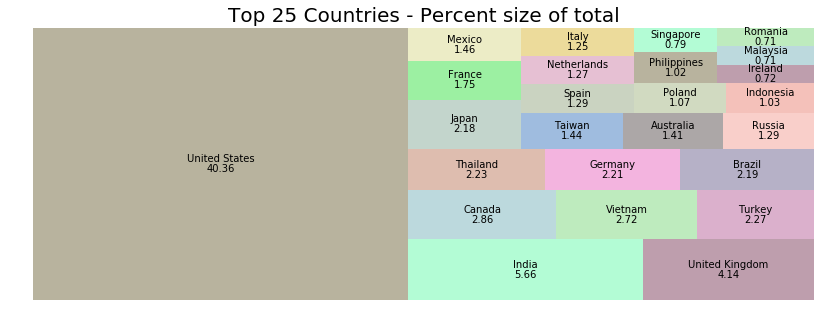

In [34]:
import random
import squarify
number_of_colors = 20
color = ["#"+''.join([random.choice('A089B14C32D65E7F') for j in range(6)]) for i in range(number_of_colors)]
country_tree = train["geoNetwork.country"].value_counts() #counting 
country_tree = round((train["geoNetwork.country"].value_counts()[:25] \
                       / len(train['geoNetwork.country']) * 100),2)
plt.figure(figsize=(14,5))
g = squarify.plot(sizes=country_tree.values, label=country_tree.index, 
                  value=country_tree.values,
                  alpha=.4, color=color)
g.set_title("Top 25 Countries - Percent size of total",fontsize=20)
g.set_axis_off()
plt.show()